In [20]:
import pandas as pd
import pyarrow.parquet as pq
import os
import airportsdata 
from geopy.distance import geodesic

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry
import pycountry_convert as pc
import plotly.io as pio
import seaborn as sns

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

# from math import radians, sin, cos, sqrt, atan2
# import heapq

# 1. Data preparation

In [21]:
# Load airport data to get latitude and longitude
airports = airportsdata.load()

# Load provided air data from 2021
dataset = pq.ParquetDataset('c:\\Users\\lukas\\OneDrive - Imperial College London\\0_Sustainable Transport\\2021_COP26',
                            ) # filters=[('columnName', 'in', filterList)]
df = dataset.read(use_threads=True).to_pandas()

In [22]:
# Exclude private jets
private_jet = ['CL60','P180','GLF5','GLEX','GLF6','F2TH','C17','LJ60','F900','GLF4','E35L','CL35','C30J','CN35','PC21','C501','C208','PC6T',
               'GL5T','ASTR','C130','BE20','H25B','L410','F100','CL30','LJ35','PC24','C56X','E55P','PAY3','PC12','B350','A124']
df = df[~df['aircraft_type_icao'].isin(private_jet)]

In [23]:
df[['total_fuel_burn',]]

,total_fuel_burn
0,60.677090
2,21.646493
3,1383.614356
4,21.170469
5,1344.642217
...,...
6299248,3764.597112
6299249,3563.176161
6299250,384.452528
6299251,4767.568897


In [28]:
# Select flights to dubai
df_dubai = df[df['destination_airport']== 'OMDB']

# Group by 'origin_airport' and select the first occurrence of each group
unique_origins = df_dubai.groupby('origin_airport').first().reset_index()
unique_origins = unique_origins[['origin_airport','longitude_first_waypoint','latitude_first_waypoint','duration_hours']]

file_path = os.path.join('output', 'unique_destinations_globally.xlsx')
unique_origins.to_excel(file_path, index=False)




In [29]:
df_dubai

file_path = os.path.join('output', 'flights_to_dubai.xlsx')
df_dubai.to_excel(file_path, index=False)

In [30]:
# Load data with delegates
delegates_path = os.getcwd() + '/data/origin_airports_delegates.csv'
data_delegates = pd.read_csv(delegates_path)

iata_icao_path = os.getcwd() + '/data/iata-icao.csv'
data_iata_icao = pd.read_csv(iata_icao_path)

In [32]:
airport_location = data_delegates.merge(data_iata_icao, on='iata', how='left')[['iata','icao','total_delegates_sample','country_code','airport','latitude','longitude']]

# Check for NAN values 
# airport_location.isna()
# airport_location = airport_location.dropna()#isna().sum()#.any(axis=1).count
# airport_location[airport_location.isna().any(axis=1)]
airport_location["country_code"][77] =  "NA"

# 2. Calculation Distance to Dubai

In [33]:
dubai_airport = pd.DataFrame({'latitude_A': [airports.get('OMDB')['lat']],
                     'longitude_A': [airports.get('OMDB')['lon']]})

delegate_airports = airport_location[['latitude','longitude']]

# Function to calculate distance using geopy.distance
def calculate_distance(row):
    coord_A = (dubai_airport['latitude_A'].iloc[0], dubai_airport['longitude_A'].iloc[0])
    coord_B = (row['latitude'], row['longitude'])
    return geodesic(coord_A, coord_B).kilometers

airport_location['distance_to_dubai'] = delegate_airports.apply(calculate_distance,axis=1)
# airport_location[airport_location['distance_to_dubai'] >= 10000]
airport_location.iloc[:3]

,iata,icao,total_delegates_sample,country_code,airport,latitude,longitude,distance_to_dubai
0,AUH,OMAA,8786,AE,Abu Dhabi International Airport,24.4330,54.6511,115.950398
1,GRU,SBGR,3618,BR,Sao Paulo/Guarulhos International Airport,-23.4262,-46.4800,12218.280093
2,PEK,ZBAA,2640,CN,Beijing Capital International Airport,40.0725,116.5980,5856.254969


In [34]:
print(airport_location[airport_location['distance_to_dubai'] >= 10000]['distance_to_dubai'].count(),"flights with over 10,000 km")

55 flights with over 10,000 km


In [36]:
print("Total km flown to COP28:",round(sum(airport_location['distance_to_dubai']),0))
print("Total Delegates:          ",sum(airport_location.total_delegates_sample))

Total km flown to COP28: 1401384.0
Total Delegates:           83148


# 3. Analysis 
## Participants from each Country

In [37]:
len(airport_location)

207

In [38]:
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except AttributeError:
        return None

plot_data = airport_location[:][:40]
plot_data
plot_data['country_name'] = plot_data['country_code'].apply(country_code_to_name)

In [39]:
# Rename due to length of name
plot_data.loc[0,"country_name"] = 'UAE'
plot_data.loc[12,"country_name"] = 'Tanzania'
plot_data.loc[17,"country_name"] = 'Korea'
plot_data.loc[20,"country_name"] = 'Congo'
plot_data.loc[21,"country_name"] = 'Russia'

In [40]:
sorted_indices = sorted(range(len(plot_data['total_delegates_GDP'])), key=lambda i: plot_data['total_delegates_GDP'][i])
sorted_categories = [plot_data['country_name'][i] for i in sorted_indices]
sorted_values = [plot_data['total_delegates_GDP'][i] for i in sorted_indices]

fig = go.Figure(data=[go.Bar(
    y=sorted_categories,  # y-axis categories
    x=sorted_values,      # x-axis values
    orientation='h'  # horizontal orientation
)])

# Add title and labels
fig.update_layout(
    title='Participants from each country (Top 40)',
    yaxis=dict(title='Countries'),
    xaxis=dict(title='# participants'),
    width=400,
    height=800
)

# Show the chart
#fig.write_image("participants_country.png")
fig.show()
# file_path = os.path.join('output', 'participants_country_GDP.png')
# non_direct.to_excel(file_path, index=False)


KeyError: 'total_delegates_GDP'

# 4. Find Flight Connections from Origin to Dubai
## 4.1 Direct Flight

In [41]:
destination_dubai = df[df['destination_airport'] == 'OMDB']
# destination_dubai[destination_dubai['origin_airport'] == 'DNMM'] #[['origin_airport_name','destination_airport_name']]
# destination_dubai['origin_airport'] = destination_dubai['origin_airport'].astype('str')#.dtypes
print(len(destination_dubai))
destination_dubai.iloc[:3]


23327


,callsign,icao_address,flight_number,tail_number,aircraft_type_icao,aircraft_engine_type,origin_airport,origin_airport_name,origin_country,destination_airport,...,so2_kg,sulphates_kg,nvpm_data_source,nvpm_mass_kg,nvpm_number,nvpm_ei_n_mean,sdr_mean,night_flight,night_segments,pct_night_dist
93,FDB1916,8963B5,FZ1916,A6-FES,B738,Jet,URML,Makhachkala Uytash International Airport,RU,OMDB,...,8.002414,0.163315,ICAO EDB,0.363317,7.447394e+18,1.116772e+15,14.200313,False,True,74.495262
213,FDB1462,8963B1,FZ1462,A6-FEO,B738,Jet,UCFM,Manas International Airport,KG,OMDB,...,11.051537,0.225542,ICAO EDB,0.491998,1.079065e+19,1.171672e+15,90.088696,False,True,23.943959
1194,FDB448,896331,FZ448,A6-FDZ,B738,Jet,VOMM,Chennai International Airport,IN,OMDB,...,10.664273,0.217638,ICAO EDB,0.453730,9.797427e+18,1.102458e+15,122.496717,False,False,0.000000


In [42]:
# # Alternative 
# def inner_merge_on_columns(df1, df2, column1, column2):
#     merged_data = []
#     for value1 in df1[column1]:
#         for value2 in df2[column2]:
#             if value1 == value2:
#                 row1 = df1[df1[column1] == value1].iloc[0].to_dict()
#                 row2 = df2[df2[column2] == value2].iloc[0].to_dict()
#                 merged_data.append({**row1, **row2})
#     return pd.DataFrame(merged_data)

# merged_df = inner_merge_on_columns(airport_location,destination_dubai,"icao","origin_airport")
# merged_df['icao'].unique()


# Merging airport origin with the existing flights from 2021
merged_df = airport_location.merge(destination_dubai, left_on='icao', right_on='origin_airport', how='inner')
test = merged_df['icao'].unique()
print("Flights who have a direct flight to Dubai:",test.size)

Flights who have a direct flight to Dubai: 87


### Select unique flights from origin to destination airport

In [43]:
merged_df = merged_df.sort_values(by=['icao', 'co2_kg'])
unique_flights_df = merged_df.drop_duplicates(subset=['icao'])
unique_flights_df.reset_index(inplace=True)

# Relevant columns
unique_flights_df = unique_flights_df[['icao', 'country_code', 'origin_airport','destination_airport', 'duration_hours',
       'distance_to_dubai', 'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
       'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg', 'latitude','longitude'
       ]]

file_path = os.path.join('output', 'flights_without_transit.xlsx')
unique_flights_df.to_excel(file_path, index=False)
unique_flights_df.iloc[:3]

,icao,country_code,origin_airport,destination_airport,duration_hours,distance_to_dubai,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,latitude,longitude
0,DAAG,DZ,DAAG,OMDB,5.69,5076.841504,0.625348,A332,28026.934111,88537.084858,377.908845,2.433629,0.560539,34473.128957,33.632321,0.686374,36.69100,3.215410
1,DGAA,GH,DGAA,OMDB,7.33,6292.961752,0.623285,B737,16668.516582,52655.843883,181.799396,1.341575,0.333370,20502.275396,20.002220,0.408209,5.60519,-0.166786
2,DTTA,TN,DTTA,OMDB,5.18,4451.568920,0.619923,B77L,30416.465762,96085.615343,554.819782,6.042459,0.608329,37412.252888,36.499759,0.744893,36.85100,10.227200


In [19]:
unique_flights_df['aircraft_type_icao'].unique()
len(unique_flights_df)

87

### Export flights without direct connection

In [20]:
# All origins who 
airport_location['existing_flight'] = airport_location['icao'].isin(merged_df['origin_airport'])
# airport_location[airport_location['existing_flight'] == False]

non_direct = airport_location[airport_location['existing_flight'] == False]
# test = pd.merge(export, data_iata_icao, on='icao', how='left')
# test.drop_duplicates(subset=['icao'])



file_path = os.path.join('output', 'non_existing_flights.xlsx')
non_direct.to_excel(file_path, index=False)

non_direct.reset_index(inplace=True)
non_direct = non_direct[['iata','icao','country_code','airport','latitude','longitude','distance_to_dubai','existing_flight']]
non_direct.iloc[:3]

,iata,icao,country_code,airport,latitude,longitude,distance_to_dubai,existing_flight
0,LOS,DNMM,NG,Murtala Muhammed International Airport,6.57737,3.32116,5899.623220,False
1,RBA,GMME,MA,Rabat-Sale Airport,34.05150,-6.75152,6003.076078,False
2,YOW,CYOW,CA,Ottawa Macdonald-Cartier International Airport,45.32250,-75.66920,10756.579780,False


## 4.2 Non-direct Flight (hub-airport required)

In [60]:
def is_defined(obj):
    if obj is not None:
        return True
    else:
        return False
    
all_flights_non_direct = None

path_transit = os.getcwd() + '/data/transit_flight_stopover.csv'
df_stopover = pd.read_csv(path_transit)
print(len(df_stopover))
df_stopover.iloc[:3]


113


,iata,icao,total_delegates,country_code,latitude,longitude,closest,second_c,third_c,fourth_c,fifth_c,sixth_c,seventh_c,eigth_c,nineth_c,tenth_c,to_dubai
0,LOS,DNMM,1411,NG,6.57737,3.32116,DGAA,FNLU,GOBD,HRYR,HJJJ,GMMN,HUEN,DAAG,DTTA,LICC,OMDB
1,YOW,CYOW,1830,CA,45.32250,-75.66920,CYYZ,KEWR,KJFK,KPHL,KBOS,KIAD,KBGR,KLCK,KSDF,KORD,OMDB
2,FIH,FZAA,590,CD,-4.38575,15.44460,FNLU,HRYR,HUEN,DGAA,HJJJ,FLLS,HKJK,HTZA,HTDA,FAOR,OMDB


In [61]:
df_stopover.iloc[:,4:14].columns

Index(['latitude', 'longitude', 'closest', 'second_c', 'third_c', 'fourth_c',
       'fifth_c', 'sixth_c', 'seventh_c', 'eigth_c'],
      dtype='object')

In [62]:
print('Flights without direct flight to dubai (hub_airport required): ',len(df_stopover), '\n')

for i_closeness in df_stopover.iloc[:,6:16].columns:
    print('-----------------------------------------------------------\n')
    merged_df = pd.merge(df_stopover, df, left_on=['icao', i_closeness], right_on=['origin_airport', 'destination_airport'], how='inner')
    merged_df = merged_df.drop_duplicates(subset=['icao'], keep='first')
    merged_df.reset_index(inplace=True)
    merged_df = merged_df.rename(columns={'destination_airport':'hub_airport'})
    merged_df = merged_df[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
        ]]
    #print(len(merged_df))
    merged_df.iloc[:3]
    print(i_closeness,'\n Flights found: ', len(merged_df))
    #############################
    ##### Hub --> Dubai
    #############################
    # Remaining flights to be found! 
    occurrences_count = merged_df['origin_airport'].value_counts().to_dict()

    # Delete the same number of occurrences from df_stopover['icao'] for each value in final_merged_df['origin_airport']
    for value, count in occurrences_count.items():
        df_stopover = df_stopover.drop(df_stopover[df_stopover['icao'] == value].head(count).index)

    len(df_stopover)

    results_closest = merged_df[['hub_airport','to_dubai']]
    destination_dubai = pd.merge(results_closest, df, left_on=['hub_airport', 'to_dubai'], right_on=['origin_airport', 'destination_airport'], how='inner')
    destination_dubai = destination_dubai.drop_duplicates(subset=['hub_airport'], keep='first')
    destination_dubai.reset_index(inplace=True)
    #print(len(destination_dubai))
    destination_dubai = destination_dubai[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
        ]]
    destination_dubai.iloc[:3]

    combined_dfs = []
    
    # Iterate over unique hub_airport values
    for hub_airport in merged_df['hub_airport'].unique():
        # Filter the row from destination_dubai
        row = destination_dubai[destination_dubai['origin_airport'] == hub_airport].iloc[0]

        # Number of times to add the row
        num_columns_to_add = (merged_df['hub_airport'] == hub_airport).sum()

        # Create a list of copies of row
        copies_of_row = [row] * num_columns_to_add

        # Concatenate the copies along the columns axis
        combined_df = pd.concat(copies_of_row, axis=1)

        # Transpose the DataFrame to have the rows and columns swapped
        combined_df = combined_df.T

        # Append the combined_df to the list
        combined_dfs.append(combined_df)

    if is_defined(all_flights_non_direct):
        all_flights_non_direct = pd.concat([all_flights_non_direct] + [merged_df] + combined_dfs, ignore_index=True)
    else:
        all_flights_non_direct = pd.concat([merged_df] + combined_dfs, ignore_index=True)
    
    print(' Total flights found: ', len(all_flights_non_direct))
    print(' Remaining flights: ',len(df_stopover),' \n')
    

# all_flights_non_direct.iloc[:3]

Flights without direct flight to dubai (hub_airport required):  113 

-----------------------------------------------------------

closest 
 Flights found:  54
 Total flights found:  108
 Remaining flights:  59  

-----------------------------------------------------------

second_c 
 Flights found:  8
 Total flights found:  124
 Remaining flights:  51  

-----------------------------------------------------------

third_c 
 Flights found:  10
 Total flights found:  144
 Remaining flights:  41  

-----------------------------------------------------------

fourth_c 
 Flights found:  2
 Total flights found:  148
 Remaining flights:  39  

-----------------------------------------------------------

fifth_c 
 Flights found:  3
 Total flights found:  154
 Remaining flights:  36  

-----------------------------------------------------------

sixth_c 
 Flights found:  1
 Total flights found:  156
 Remaining flights:  35  

-----------------------------------------------------------

seventh

In [ ]:
d

In [63]:
file_path = os.path.join('output', 'flights_non_direct_missing30.xlsx')
all_flights_non_direct.to_excel(file_path, index=False)

In [64]:
all_flights_non_direct.iloc[:3]

,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai
0,DNMM,DGAA,0.607831,A332,4349.248039,13739.274554,91.83927,0.886448,0.086985,5349.575088,5.219098,0.106512,OMDB
1,CYOW,CYYZ,0.751742,A320,1577.426378,4983.089929,21.963573,0.399045,0.031549,1940.234445,1.892912,0.038631,OMDB
2,FZAA,FNLU,0.613962,A333,4823.481159,15237.376981,96.609533,1.785834,0.09647,5932.881825,5.788177,0.118126,OMDB


## 4.3 Missing flights from non-direct

In [65]:
file_path = os.path.join('output', 'missing31_non_direct_no_connection.xlsx')
df_stopover.to_excel(file_path, index=False)

Change airport ICAO name, and re-check direct and non-direct

In [66]:
# GOOY/GOBD - GOGS
# FCBB - FZAA
# FYWH/FYWE/FYWB
# SPIM - SPJC
# FKKY - FKKD
# OYSN - OYSY
# NFNA - NFFN
# UAFM - UCFM
# ZMUB - ZMCK
# NVVV
# NFTF
# PLCH - NGTA
# FDMS - FDSK
# NGFU
# NSFA
# FXMM
# SLLP - SLVR
# HSSK
# LSZC - LSZH
# TLPC - TLPL
# SVMI
# TDPD
# MYSM - MYNN
# PTPN
# NIUE
# NCRG
# LESU - LEBL
# ZKPY

path_transit = os.getcwd() + '/data/data_missing31_non_direct_no_connection.xlsx'
missing_flights = pd.read_excel(path_transit)
print(len(missing_flights))
missing_flights.iloc[:3]

28


,iata,icao,total_delegates,country_code,latitude,longitude,closest,second_c,third_c,fourth_c,fifth_c,sixth_c,seventh_c,eigth_c,nineth_c,tenth_c,to_dubai
0,DKR,GOBD,560,SN,14.73970,-17.4902,GOBD,DGAA,GMMN,LPPT,LEMD,DAAG,LEZG,LEBL,LFBO,DTTA,OMDB
1,BZV,FZAA,284,CG,-4.25167,15.2531,FNLU,HRYR,HUEN,DGAA,HJJJ,FLLS,HKJK,HTZA,HTDA,FAOR,OMDB
2,WDH,FYWB,212,XX,-22.47990,17.4709,FAOR,FACT,FNLU,FALE,FLLS,HRYR,HTDA,HUEN,HTZA,HKJK,OMDB


### 4.2.1 Find direct flights from missing non-direct

In [67]:
merged_df = missing_flights.merge(destination_dubai, left_on='icao', right_on='origin_airport', how='inner')
test = merged_df['icao'].unique()

all_flights_non_direct = None

print("Flights who have a direct flight to Dubai:",test.size)

Flights who have a direct flight to Dubai: 0


### 4.2.2 Find non-direct flights from missing non-direct

In [68]:
missing_flights.iloc[:,6:16].columns

Index(['closest', 'second_c', 'third_c', 'fourth_c', 'fifth_c', 'sixth_c',
       'seventh_c', 'eigth_c', 'nineth_c', 'tenth_c'],
      dtype='object')

In [69]:
print('Flights without direct flight to dubai (hub_airport required): ',len(missing_flights), '\n')

for i_closeness in missing_flights.iloc[:,6:16].columns:
    print('-----------------------------------------------------------\n')
    merged_df = pd.merge(missing_flights, df, left_on=['icao', i_closeness], right_on=['origin_airport', 'destination_airport'], how='inner')
    merged_df = merged_df.drop_duplicates(subset=['icao'], keep='first')
    merged_df.reset_index(inplace=True)
    merged_df = merged_df.rename(columns={'destination_airport':'hub_airport'})
    merged_df = merged_df[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
        ]]
    #print(len(merged_df))
    merged_df.iloc[:3]
    print(i_closeness,'\n Flights found: ', len(merged_df))
    #############################
    ##### Hub --> Dubai
    #############################
    # Remaining flights to be found! 
    occurrences_count = merged_df['origin_airport'].value_counts().to_dict()
    
    # Delete the same number of occurrences from missing_flights['icao'] for each value in final_merged_df['origin_airport']
    for value, count in occurrences_count.items():
        missing_flights = missing_flights.drop(missing_flights[missing_flights['icao'] == value].head(count).index)

    len(missing_flights)

    results_closest = merged_df[['hub_airport','to_dubai']]
    destination_dubai = pd.merge(results_closest, df, left_on=['hub_airport', 'to_dubai'], right_on=['origin_airport', 'destination_airport'], how='inner')
    destination_dubai = destination_dubai.drop_duplicates(subset=['hub_airport'], keep='first')
    destination_dubai.reset_index(inplace=True)
    # print(len(destination_dubai))
    destination_dubai = destination_dubai[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
        ]]
    destination_dubai.iloc[:3]

    combined_dfs = []
    
    # Iterate over unique hub_airport values
    for hub_airport in merged_df['hub_airport'].unique():
        # Filter the row from destination_dubai
        row = destination_dubai[destination_dubai['origin_airport'] == hub_airport].iloc[0]

        # Number of times to add the row
        num_columns_to_add = (merged_df['hub_airport'] == hub_airport).sum()

        # Create a list of copies of row
        copies_of_row = [row] * num_columns_to_add

        # Concatenate the copies along the columns axis
        combined_df = pd.concat(copies_of_row, axis=1)

        # Transpose the DataFrame to have the rows and columns swapped
        combined_df = combined_df.T

        # Append the combined_df to the list
        combined_dfs.append(combined_df)

    if is_defined(all_flights_non_direct):
        all_flights_non_direct = pd.concat([all_flights_non_direct] + [merged_df] + combined_dfs, ignore_index=True)
    else:
        all_flights_non_direct = pd.concat([merged_df] + combined_dfs, ignore_index=True)
    
    print(' Total flights found: ', len(all_flights_non_direct))
    print(' Remaining flights: ',len(missing_flights),' \n')
    

# all_flights_non_direct.iloc[:3]

Flights without direct flight to dubai (hub_airport required):  28 

-----------------------------------------------------------

closest 
 Flights found:  10
 Total flights found:  20
 Remaining flights:  18  

-----------------------------------------------------------

second_c 
 Flights found:  0
 Total flights found:  20
 Remaining flights:  18  

-----------------------------------------------------------

third_c 
 Flights found:  1
 Total flights found:  22
 Remaining flights:  17  

-----------------------------------------------------------

fourth_c 
 Flights found:  0
 Total flights found:  22
 Remaining flights:  17  

-----------------------------------------------------------

fifth_c 
 Flights found:  0
 Total flights found:  22
 Remaining flights:  17  

-----------------------------------------------------------

sixth_c 
 Flights found:  1
 Total flights found:  24
 Remaining flights:  16  

-----------------------------------------------------------

seventh_c 
 Fli

In [70]:
missing_flights['total_delegates'].sum()

1009

In [71]:
len(missing_flights)

16

In [72]:
all_flights_non_direct

,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai
0,GOBD,GOBD,0.621901,AT76,276.447846,873.298746,4.18542,0.143753,0.005529,340.030851,0.331737,0.00677,OMDB
1,FZAA,FNLU,0.613962,A333,4823.481159,15237.376981,96.609533,1.785834,0.09647,5932.881825,5.788177,0.118126,OMDB
2,SPJC,SBGR,0.787394,A20N,8445.344107,26678.842034,95.159244,0.512901,0.168907,10387.773252,10.134413,0.206825,OMDB
3,NFFN,YBBN,0.643185,B38M,7256.460574,22923.158953,131.652065,0.790792,0.145129,8925.446506,8.707753,0.177709,OMDB
4,UCFM,UCFM,0.654927,RJ85,725.322898,2291.295036,9.18868,0.362971,0.014506,892.147165,0.870387,0.017763,OMDB
5,SLVR,SBGR,0.787394,B738,5903.455744,18649.016697,68.769429,0.832445,0.118069,7261.250566,7.084147,0.144574,OMDB
6,LSZH,LSZH,0.699784,E290,739.22615,2335.215408,8.726231,0.029209,0.014785,909.248165,0.887071,0.018103,OMDB
7,TLPL,KMIA,0.787394,B738,7712.484434,24363.738326,89.631012,0.749142,0.15425,9486.355853,9.254981,0.188877,OMDB
8,MYNN,KMIA,0.787394,B735,1350.522177,4266.299557,15.990608,0.473291,0.02701,1661.142278,1.620627,0.033074,OMDB
9,LEBL,LEBL,0.705842,A320,1719.693865,5432.51292,17.918905,0.274574,0.034394,2115.223454,2.063633,0.042115,OMDB


In [73]:
all_flights_non_direct['aircraft_type_icao'].unique() 

array(['AT76', 'A333', 'A20N', 'B38M', 'RJ85', 'B738', 'E290', 'B735',
       'A320', 'B77W', 'B737', 'A332'], dtype=object)

In [75]:
file_path = os.path.join('output', 'flights_non_direct_missing14.xlsx') 
all_flights_non_direct.to_excel(file_path, index=False)

### Forcing flights over busiest airports in middle east

In [83]:
# https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_Middle_East
missing_flights['closest'] = 'OTHH'
missing_flights['second_c'] = 'OEJN'
missing_flights['third_c'] = 'OERK'
missing_flights['fourth_c'] = 'HECA'
missing_flights['fifth_c'] = 'OMAA'
missing_flights['sixth_c'] = 'HEGN'
missing_flights['seventh_c'] = 'OLBA'
missing_flights['eigth_c'] = 'LTAI'
missing_flights['nineth_c'] = 'LTFJ' 
missing_flights['tenth_c'] = 'LTFM'

In [92]:
print('Flights without direct flight to dubai (hub_airport required): ',len(missing_flights), '\n')

for i_closeness in missing_flights.iloc[:,6:16].columns:
    print('-----------------------------------------------------------\n')
    merged_df = pd.merge(missing_flights, df, left_on=['icao', i_closeness], right_on=['origin_airport', 'destination_airport'], how='inner')
    merged_df = merged_df.drop_duplicates(subset=['icao'], keep='first')
    merged_df.reset_index(inplace=True)
    merged_df = merged_df.rename(columns={'destination_airport':'hub_airport'})
    merged_df = merged_df[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
        ]]
    #print(len(merged_df))
    merged_df.iloc[:3]
    print(i_closeness,'\n Flights found: ', len(merged_df))
    #############################
    ##### Hub --> Dubai
    #############################
    # Remaining flights to be found! 
    occurrences_count = merged_df['origin_airport'].value_counts().to_dict()

    # Delete the same number of occurrences from missing_flights['icao'] for each value in final_merged_df['origin_airport']
    for value, count in occurrences_count.items():
        missing_flights = missing_flights.drop(missing_flights[missing_flights['icao'] == value].head(count).index)

    len(missing_flights)

    results_closest = merged_df[['hub_airport','to_dubai']]
    destination_dubai = pd.merge(results_closest, df, left_on=['hub_airport', 'to_dubai'], right_on=['origin_airport', 'destination_airport'], how='inner')
    destination_dubai = destination_dubai.drop_duplicates(subset=['hub_airport'], keep='first')
    destination_dubai.reset_index(inplace=True)
    #print(len(destination_dubai))
    destination_dubai = destination_dubai[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
        ]]
    destination_dubai.iloc[:3]

    combined_dfs = []
    
    # Iterate over unique hub_airport values
    for hub_airport in merged_df['hub_airport'].unique():
        # Filter the row from destination_dubai
        row = destination_dubai[destination_dubai['origin_airport'] == hub_airport].iloc[0]

        # Number of times to add the row
        num_columns_to_add = (merged_df['hub_airport'] == hub_airport).sum()

        # Create a list of copies of row
        copies_of_row = [row] * num_columns_to_add

        # Concatenate the copies along the columns axis
        combined_df = pd.concat(copies_of_row, axis=1)

        # Transpose the DataFrame to have the rows and columns swapped
        combined_df = combined_df.T

        # Append the combined_df to the list
        combined_dfs.append(combined_df)

    if is_defined(all_flights_non_direct):
        all_flights_non_direct = pd.concat([all_flights_non_direct] + [merged_df] + combined_dfs, ignore_index=True)
    else:
        all_flights_non_direct = pd.concat([merged_df] + combined_dfs, ignore_index=True)
    
    print(' Total flights found: ', len(all_flights_non_direct))
    print(' Remaining flights: ',len(missing_flights),' \n')
    

# all_flights_non_direct.iloc[:3]

Flights without direct flight to dubai (hub_airport required):  14 

-----------------------------------------------------------

closest 
 Flights found:  0
 Total flights found:  312
 Remaining flights:  14  

-----------------------------------------------------------

second_c 
 Flights found:  0
 Total flights found:  312
 Remaining flights:  14  

-----------------------------------------------------------

third_c 
 Flights found:  0
 Total flights found:  312
 Remaining flights:  14  

-----------------------------------------------------------

fourth_c 
 Flights found:  0
 Total flights found:  312
 Remaining flights:  14  

-----------------------------------------------------------

fifth_c 
 Flights found:  0
 Total flights found:  312
 Remaining flights:  14  

-----------------------------------------------------------

sixth_c 
 Flights found:  0
 Total flights found:  312
 Remaining flights:  14  

-----------------------------------------------------------

seventh_c 

In [82]:
missing_flights['total_delegates'].sum()

825

In [76]:
missing_flights

,iata,icao,total_delegates,country_code,latitude,longitude,closest,second_c,third_c,fourth_c,fifth_c,sixth_c,seventh_c,eigth_c,nineth_c,tenth_c,to_dubai
2,WDH,FYWB,212,XX,-22.47990,17.4709,FAOR,FACT,FNLU,FALE,FLLS,HRYR,HTDA,HUEN,HTZA,HKJK,OMDB
5,SAH,OYSY,153,YE,15.47640,44.2197,HDAM,HHAS,HCMH,HSSJ,OEJN,HSSS,HAAB,OERK,OOSA,OEMA,OMDB
9,VLI,NVVV,99,VU,-17.69930,168.3200,YBBN,YSSY,YMML,YPDN,RPMD,YPPH,RPLL,RPLC,RJAA,RJTT,OMDB
10,TBU,NFTF,79,TO,-21.24120,-175.1500,KSFO,KLAX,PANC,KSEA,KIAH,KDFW,KMEM,KMIA,KMCO,KSDF,OMDB
11,CXI,NGTA,71,KI,1.98616,-157.3500,KSFO,KLAX,KSEA,PANC,KDFW,KIAH,KMEM,KORD,KSDF,KMCO,OMDB
12,MTS,FDSK,61,SZ,-26.52900,31.3075,FAOR,FALE,FLLS,FACT,HTDA,HTZA,HRYR,FNLU,HKJK,HUEN,OMDB
13,FUN,NGFU,54,TV,-8.52500,179.1960,YBBN,YSSY,YMML,YPDN,RPMD,RJAA,RJTT,RJBB,RPLL,RPLC,OMDB
14,APW,NSFA,53,WS,-13.83000,-172.0080,KSFO,KLAX,PANC,KSEA,KIAH,KDFW,KMEM,KMIA,KMCO,KSDF,OMDB
15,MSU,FXMM,48,LS,-29.46230,27.5525,FAOR,FALE,FACT,FLLS,FNLU,HTDA,HTZA,HRYR,HKJK,HUEN,OMDB
17,KRT,HSSK,46,SD,15.58950,32.5532,HHAS,OEJN,HAAB,HJJJ,HDAM,OEMA,OEAO,HESH,HCMH,HECA,OMDB


In [79]:
dubai_airport = pd.DataFrame({'latitude_A': [airports.get('OMDB')['lat']],
                     'longitude_A': [airports.get('OMDB')['lon']]})

delegate_airports = missing_flights[['latitude','longitude']]

# Function to calculate distance using geopy.distance
def calculate_distance(row):
    coord_A = (dubai_airport['latitude_A'].iloc[0], dubai_airport['longitude_A'].iloc[0])
    coord_B = (row['latitude'], row['longitude'])
    return geodesic(coord_A, coord_B).kilometers

missing_flights['distance_to_dubai'] = delegate_airports.apply(calculate_distance,axis=1)

print("Total km flown of missing 825 to COP28:",round(sum(missing_flights['distance_to_dubai']),0))
print("Total km flown per person of missing 825 to COP28 :",round(sum(missing_flights['distance_to_dubai'] / len(missing_flights)),0))
privat_jet_pp_co2kg_km = 0.101
print("Average co2:",round(sum(missing_flights['distance_to_dubai']),0))


Total km flown of missing 825 to COP28: 169787.0
Total km flown per person of missing 825 to COP28 : 10612.0
Average co2: 169787.0


In [85]:
missing_flights.iloc[:3]

,iata,icao,total_delegates,country_code,latitude,longitude,closest,second_c,third_c,fourth_c,fifth_c,sixth_c,seventh_c,eigth_c,nineth_c,tenth_c,to_dubai,distance_to_dubai
2,WDH,FYWB,212,XX,-22.4799,17.4709,FAOR,FACT,FNLU,FALE,FLLS,HRYR,HTDA,HUEN,HTZA,HKJK,OMDB,6680.442821
5,SAH,OYSY,153,YE,15.4764,44.2197,HDAM,HHAS,HCMH,HSSJ,OEJN,HSSS,HAAB,OERK,OOSA,OEMA,OMDB,1587.508910
9,VLI,NVVV,99,VU,-17.6993,168.3200,YBBN,YSSY,YMML,YPDN,RPMD,YPPH,RPLL,RPLC,RJAA,RJTT,OMDB,13099.790633


In [82]:
file_path = os.path.join('output', 'missing14flights_distance_to_dubai.xlsx')
missing_flights.to_excel(file_path, index=False)

# 5. Data Analysis

## 5.1 Descriptive Statistics

In [103]:
# Descriptive Statistics
print("Descriptive Statistics:")
descriptive_direct = unique_flights_df.describe()

file_path = os.path.join('output', 'direct_flights_statistics.xlsx')
descriptive_direct.to_excel(file_path, index=False)

descriptive_direct

Descriptive Statistics:


,distance_to_dubai,assumed_load_factor,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,latitude,longitude
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,4117.450740,0.658435,20312.253435,64166.408600,350.051546,2.194765,0.406245,24984.071725,24.374704,0.497443,29.062284,40.668405
std,2215.971153,0.062478,23917.507950,75555.407614,485.396276,2.787844,0.478350,29418.534779,28.701010,0.585735,22.628034,39.159037
min,115.950398,0.529138,466.979806,1475.189208,7.070074,0.042784,0.009340,574.385162,0.560376,0.011436,-33.946100,-73.778900
25%,2651.702750,0.624910,5965.162708,18843.948996,69.048980,0.658159,0.119303,7337.150131,7.158195,0.146086,12.614200,15.263200
50%,4058.358801,0.650973,9332.396498,29481.040536,127.850930,0.906594,0.186648,11478.847692,11.198876,0.228548,36.691000,32.443500
75%,5152.858822,0.718041,31905.259530,100788.714855,535.402381,2.790448,0.638105,39243.469222,38.286311,0.781353,45.983300,56.602700
max,12218.280093,0.793083,138084.468773,436208.836852,2630.922793,17.105190,2.761689,169843.896590,165.701363,3.381660,60.317200,151.177000


In [104]:
numeric_columns = ['assumed_load_factor', 'total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg']
all_flights_non_direct[numeric_columns] = all_flights_non_direct[numeric_columns].astype(float)

# Convert categorical columns to appropriate data types
categorical_columns = ['origin_airport', 'hub_airport', 'aircraft_type_icao', 'to_dubai']
all_flights_non_direct[categorical_columns] = all_flights_non_direct[categorical_columns].astype(str)

In [105]:
non_direct_stats = all_flights_non_direct[['assumed_load_factor','total_fuel_burn','co2_kg','nox_kg','hc_kg','oc_kg','h2o_kg','so2_kg','sulphates_kg']]

print("Descriptive Statistics:")
descriptive_non_direct = non_direct_stats.describe()

file_path = os.path.join('output', 'non_direct_flights_statistics.xlsx')
descriptive_non_direct.to_excel(file_path, index=False)



Descriptive Statistics:


## 5.2 Sensitivity Analysis
### 5.2.1 Direct Flights

In [50]:
unique_flights_df.columns

Index(['icao', 'country_code', 'origin_airport', 'destination_airport',
       'distance_to_dubai', 'assumed_load_factor', 'aircraft_type_icao',
       'total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg',
       'so2_kg', 'sulphates_kg', 'latitude', 'longitude'],
      dtype='object')

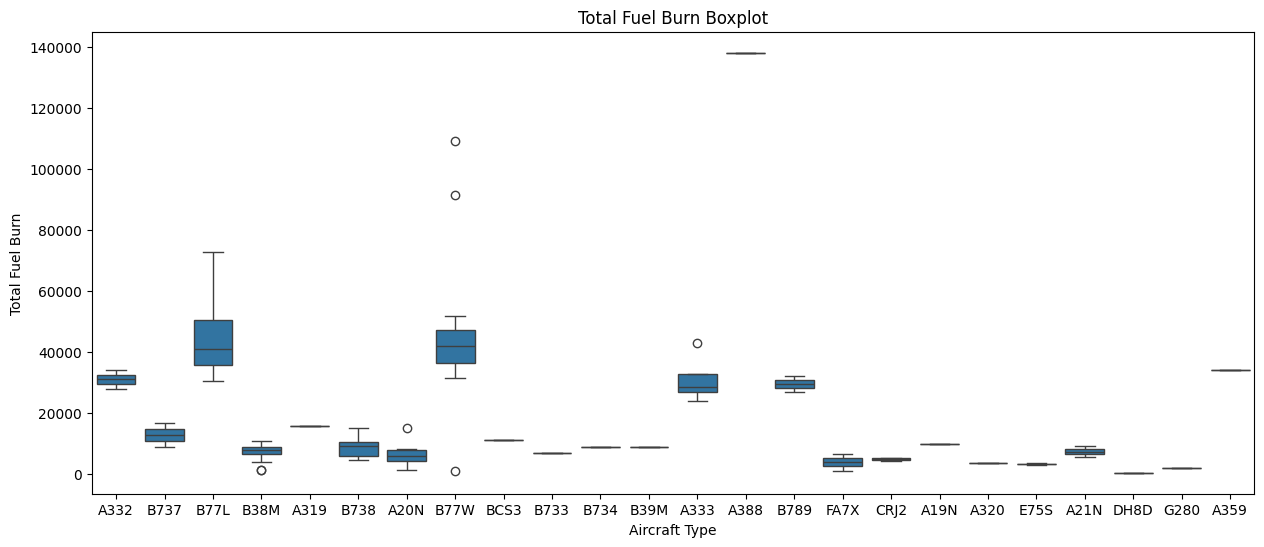

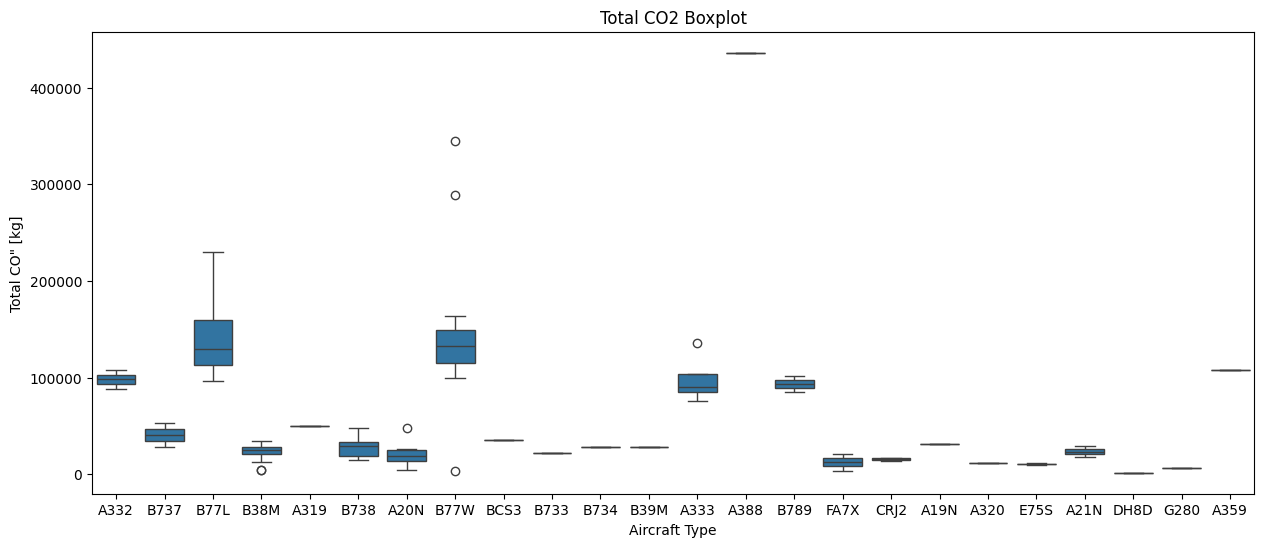

In [55]:
# Boxplot for total_fuel_burn
plt.figure(figsize=(15, 6))
sns.boxplot(x='aircraft_type_icao', y='total_fuel_burn', data=unique_flights_df)
plt.title('Total Fuel Burn Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total Fuel Burn')
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(x='aircraft_type_icao', y='co2_kg', data=unique_flights_df)
plt.title('Total CO2 Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total CO" [kg]')
plt.show()

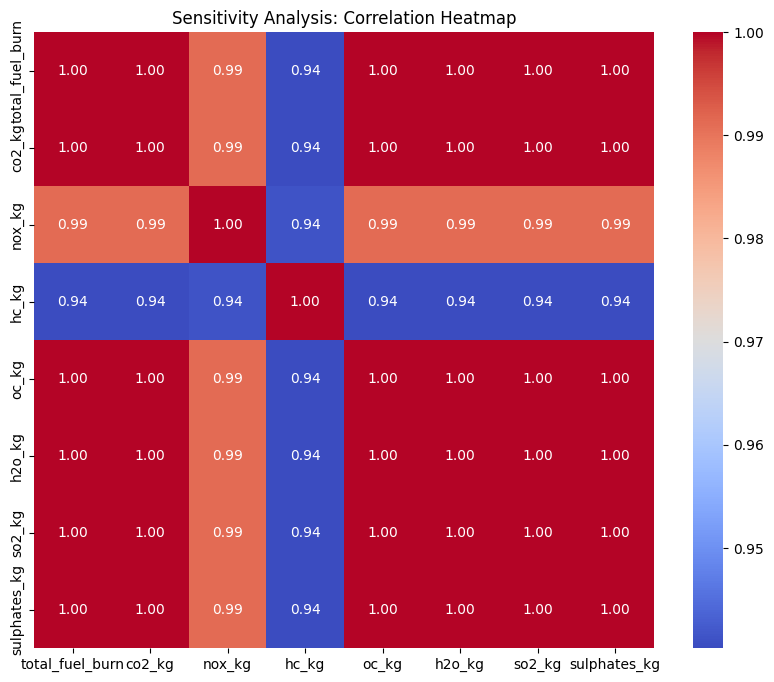

In [48]:
# Sensitivity Analysis
sensitivity_data = unique_flights_df[['total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg']]

plt.figure(figsize=(10, 8))
sns.heatmap(sensitivity_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Sensitivity Analysis: Correlation Heatmap')
plt.show()

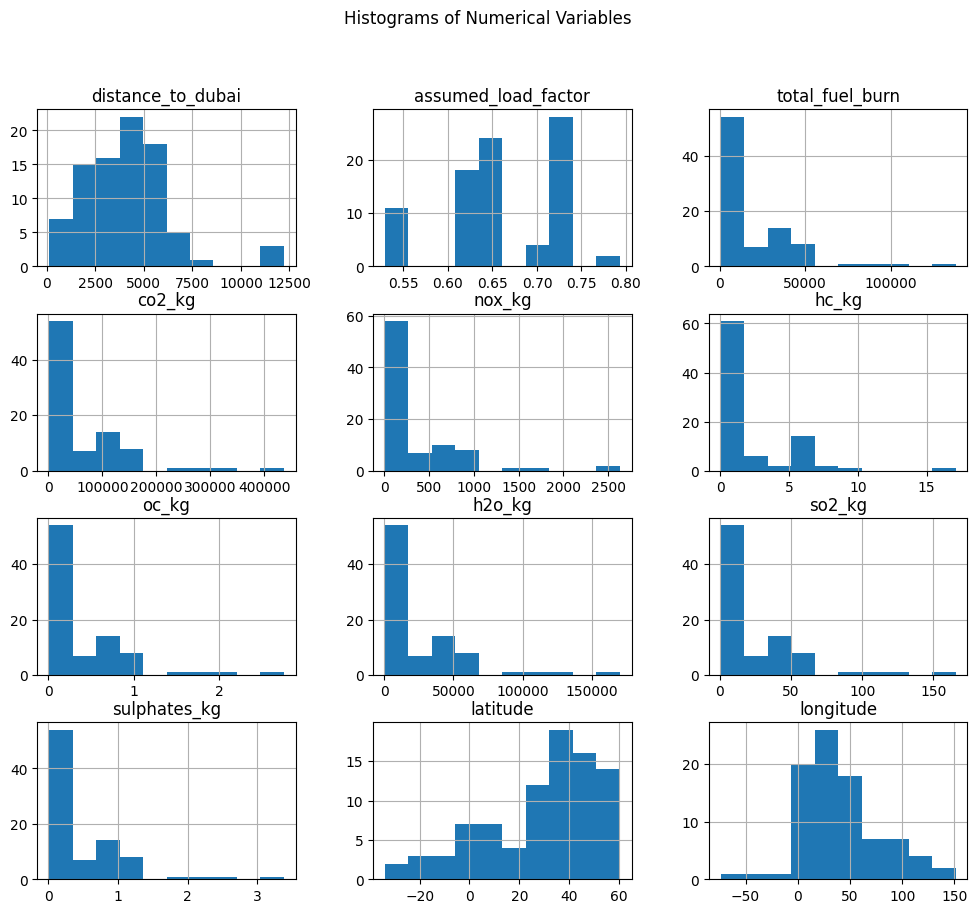

In [56]:
# Histograms
unique_flights_df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

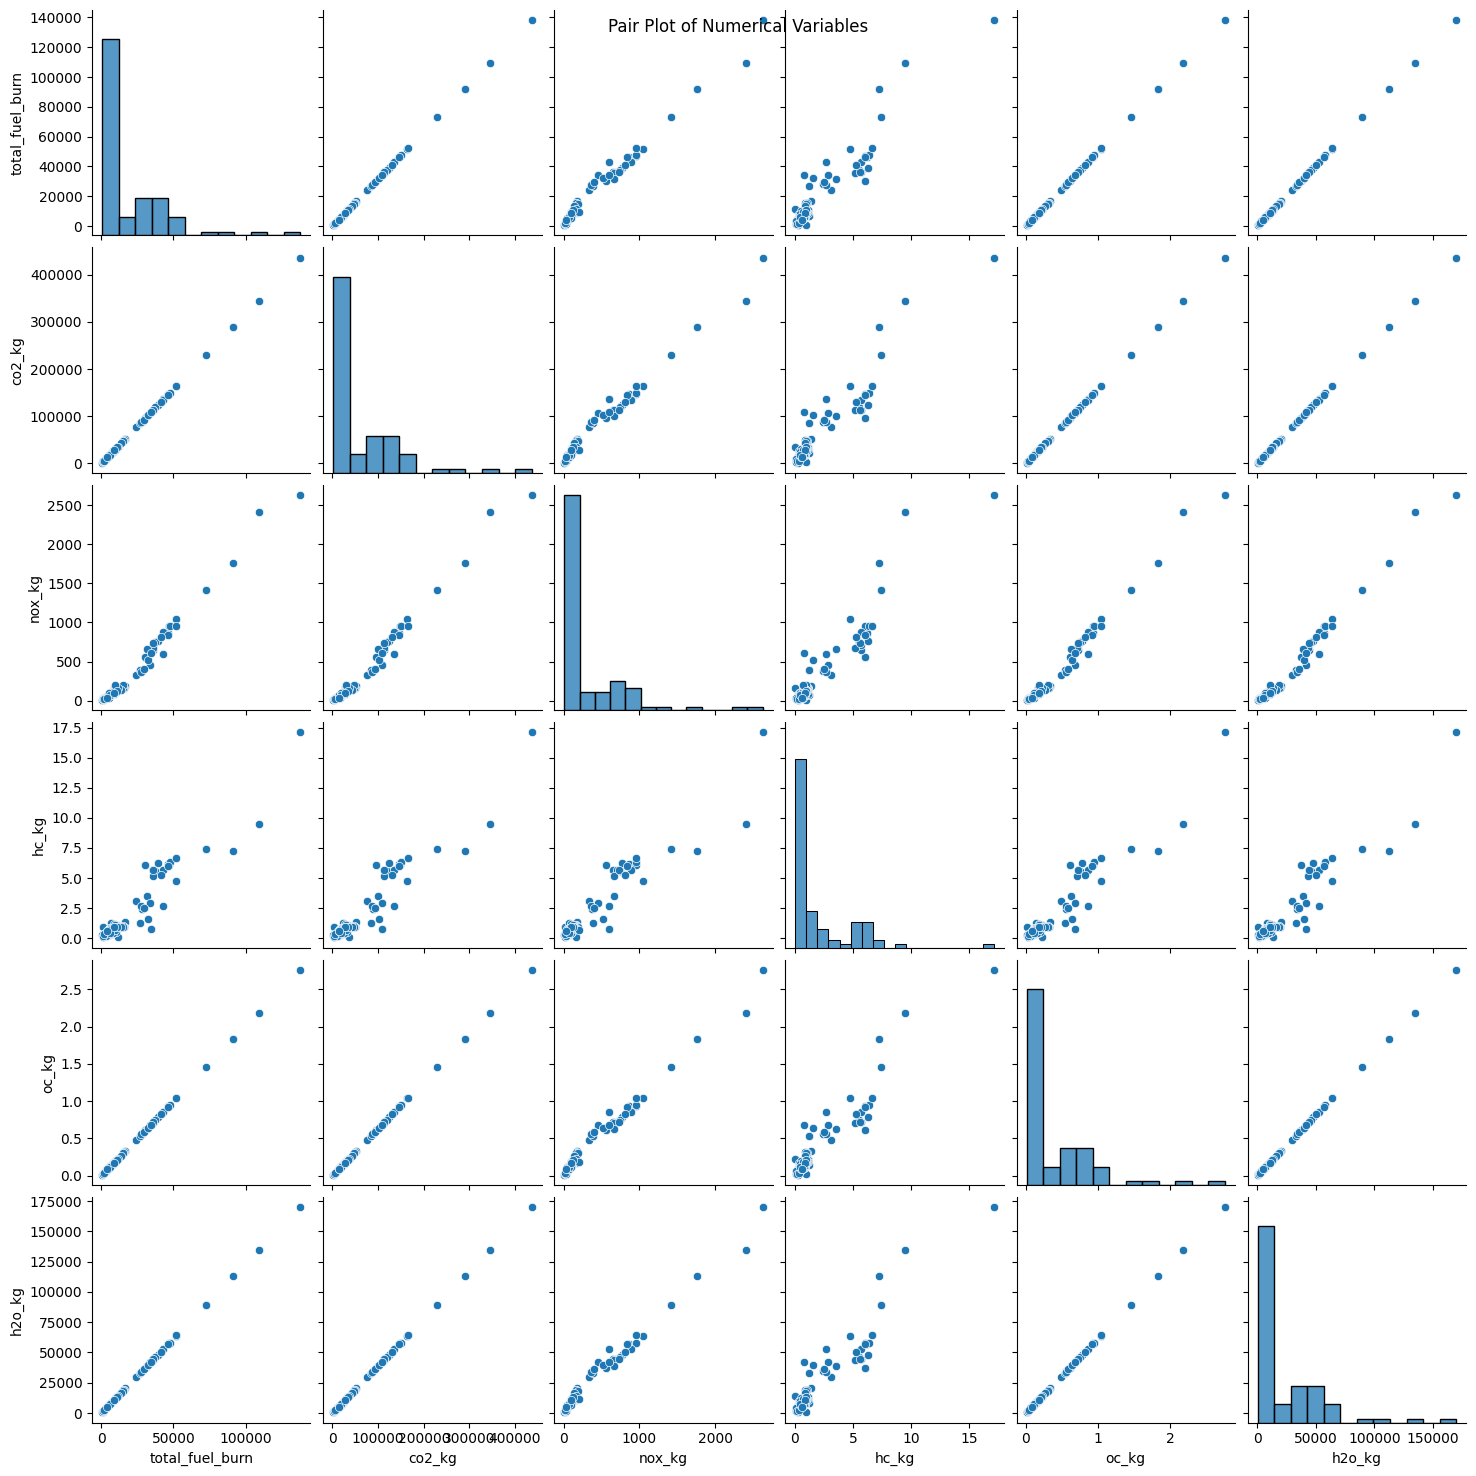

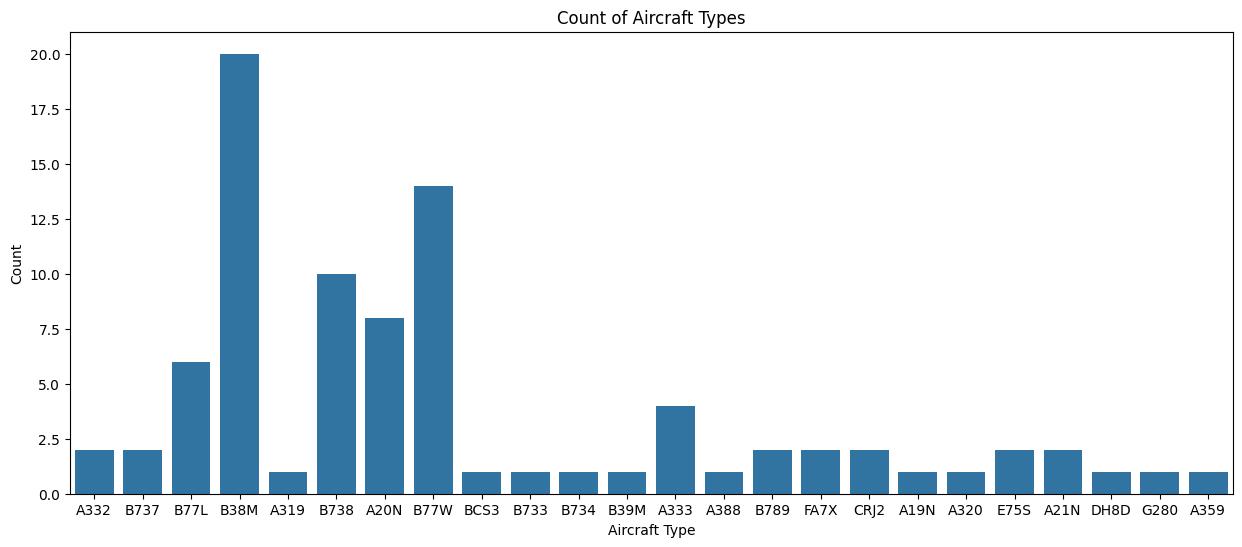

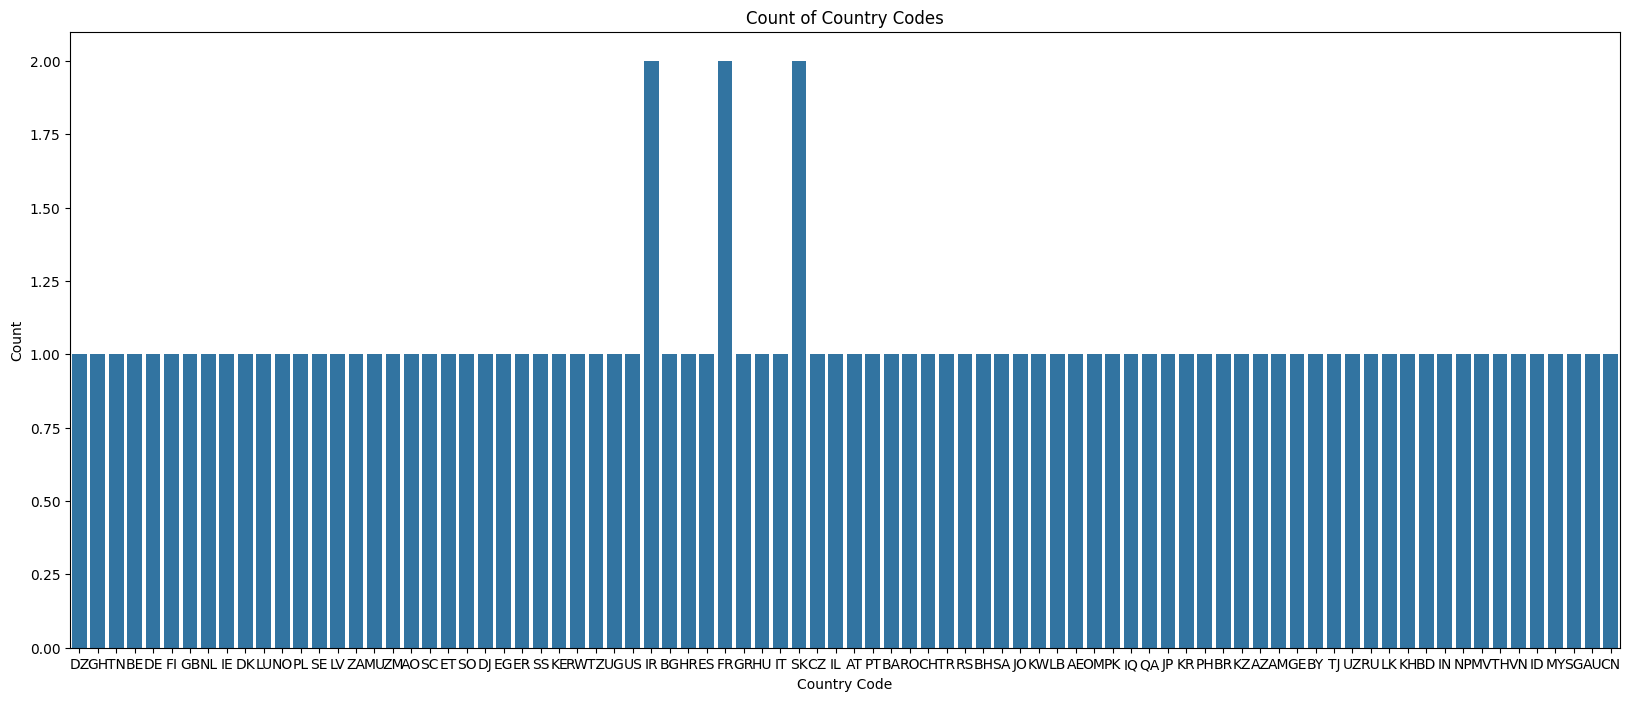

In [74]:
# Scatter Plots
sns.pairplot(unique_flights_df[['total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg']])
plt.suptitle('Pair Plot of Numerical Variables')
plt.show()

# Bar Plots
plt.figure(figsize=(15, 6))
sns.countplot(x='aircraft_type_icao', data=unique_flights_df)
plt.title('Count of Aircraft Types')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.show()

# Count Plots
plt.figure(figsize=(20, 8))
sns.countplot(x='country_code', data=unique_flights_df)
plt.title('Count of Country Codes')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.show()

### 5.2.2 Non-Direct

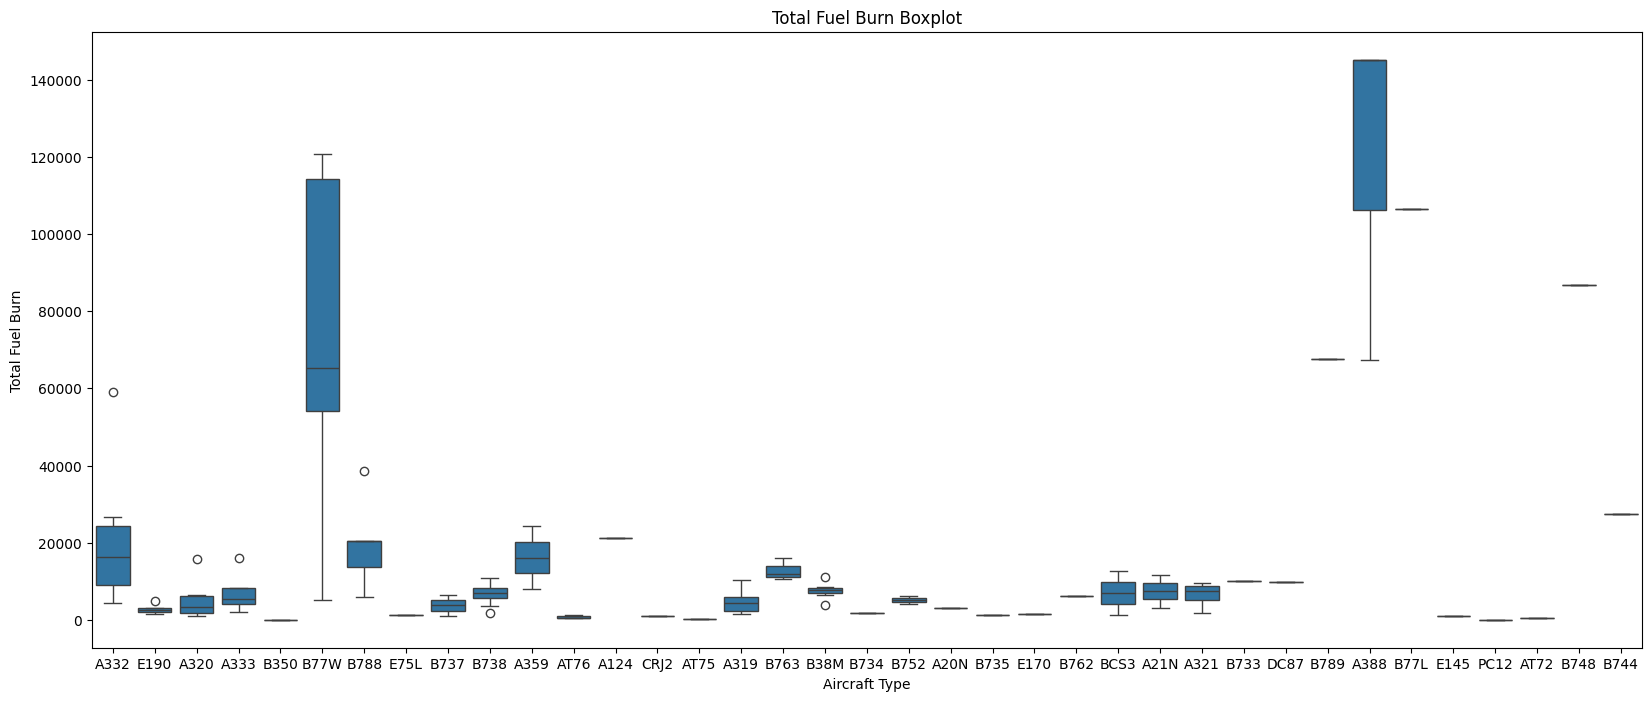

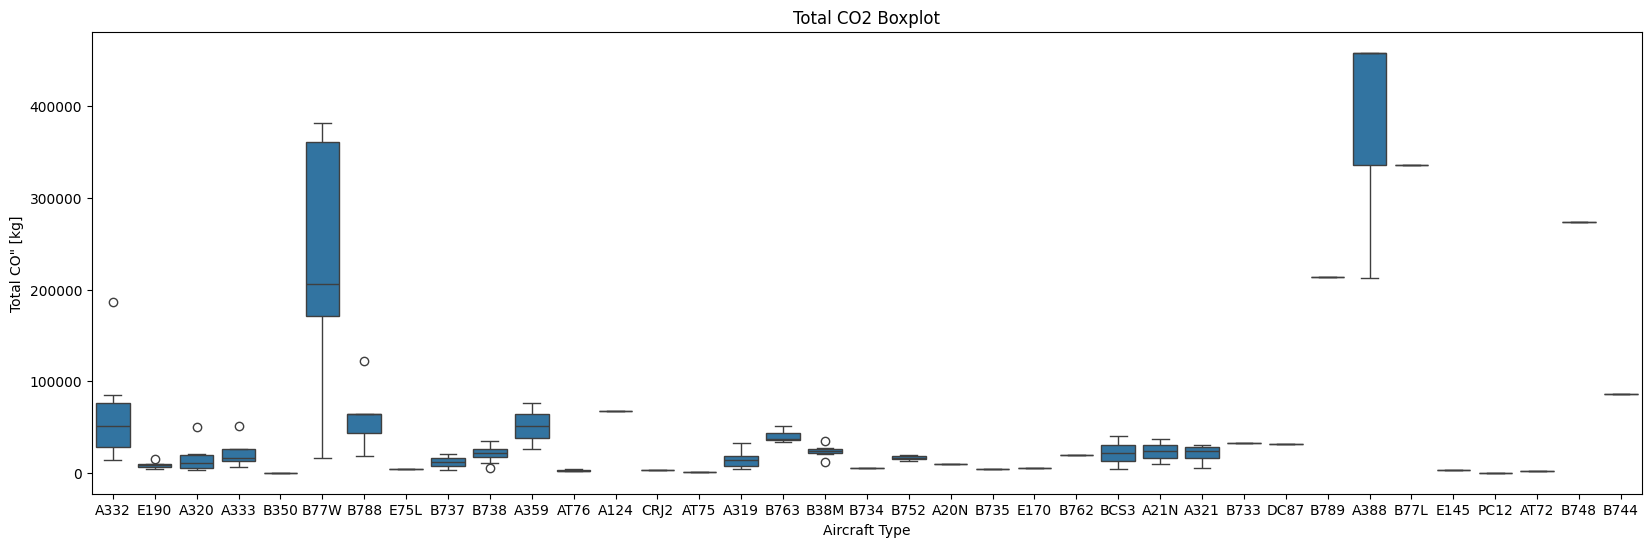

In [71]:
# Boxplot for total_fuel_burn
plt.figure(figsize=(20, 8))
sns.boxplot(x='aircraft_type_icao', y='total_fuel_burn', data=all_flights_non_direct)
plt.title('Total Fuel Burn Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total Fuel Burn')
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(x='aircraft_type_icao', y='co2_kg', data=all_flights_non_direct)
plt.title('Total CO2 Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total CO" [kg]')
plt.show()


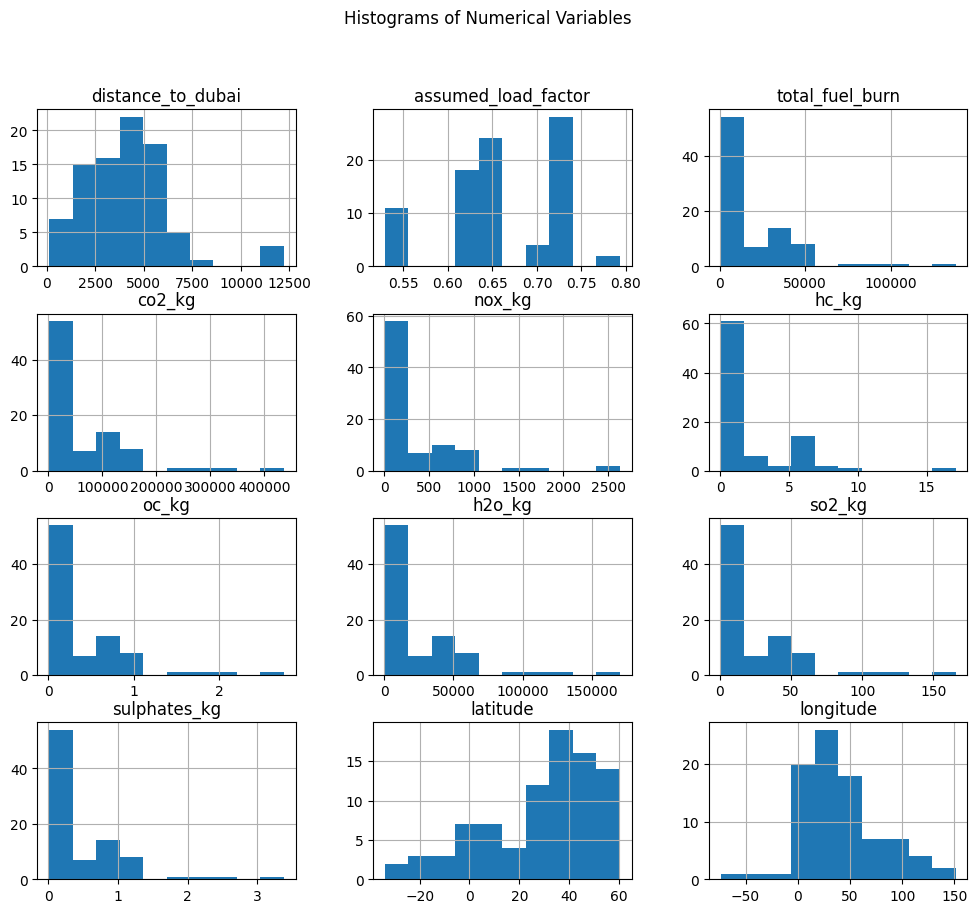

In [87]:
# Histograms
unique_flights_df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

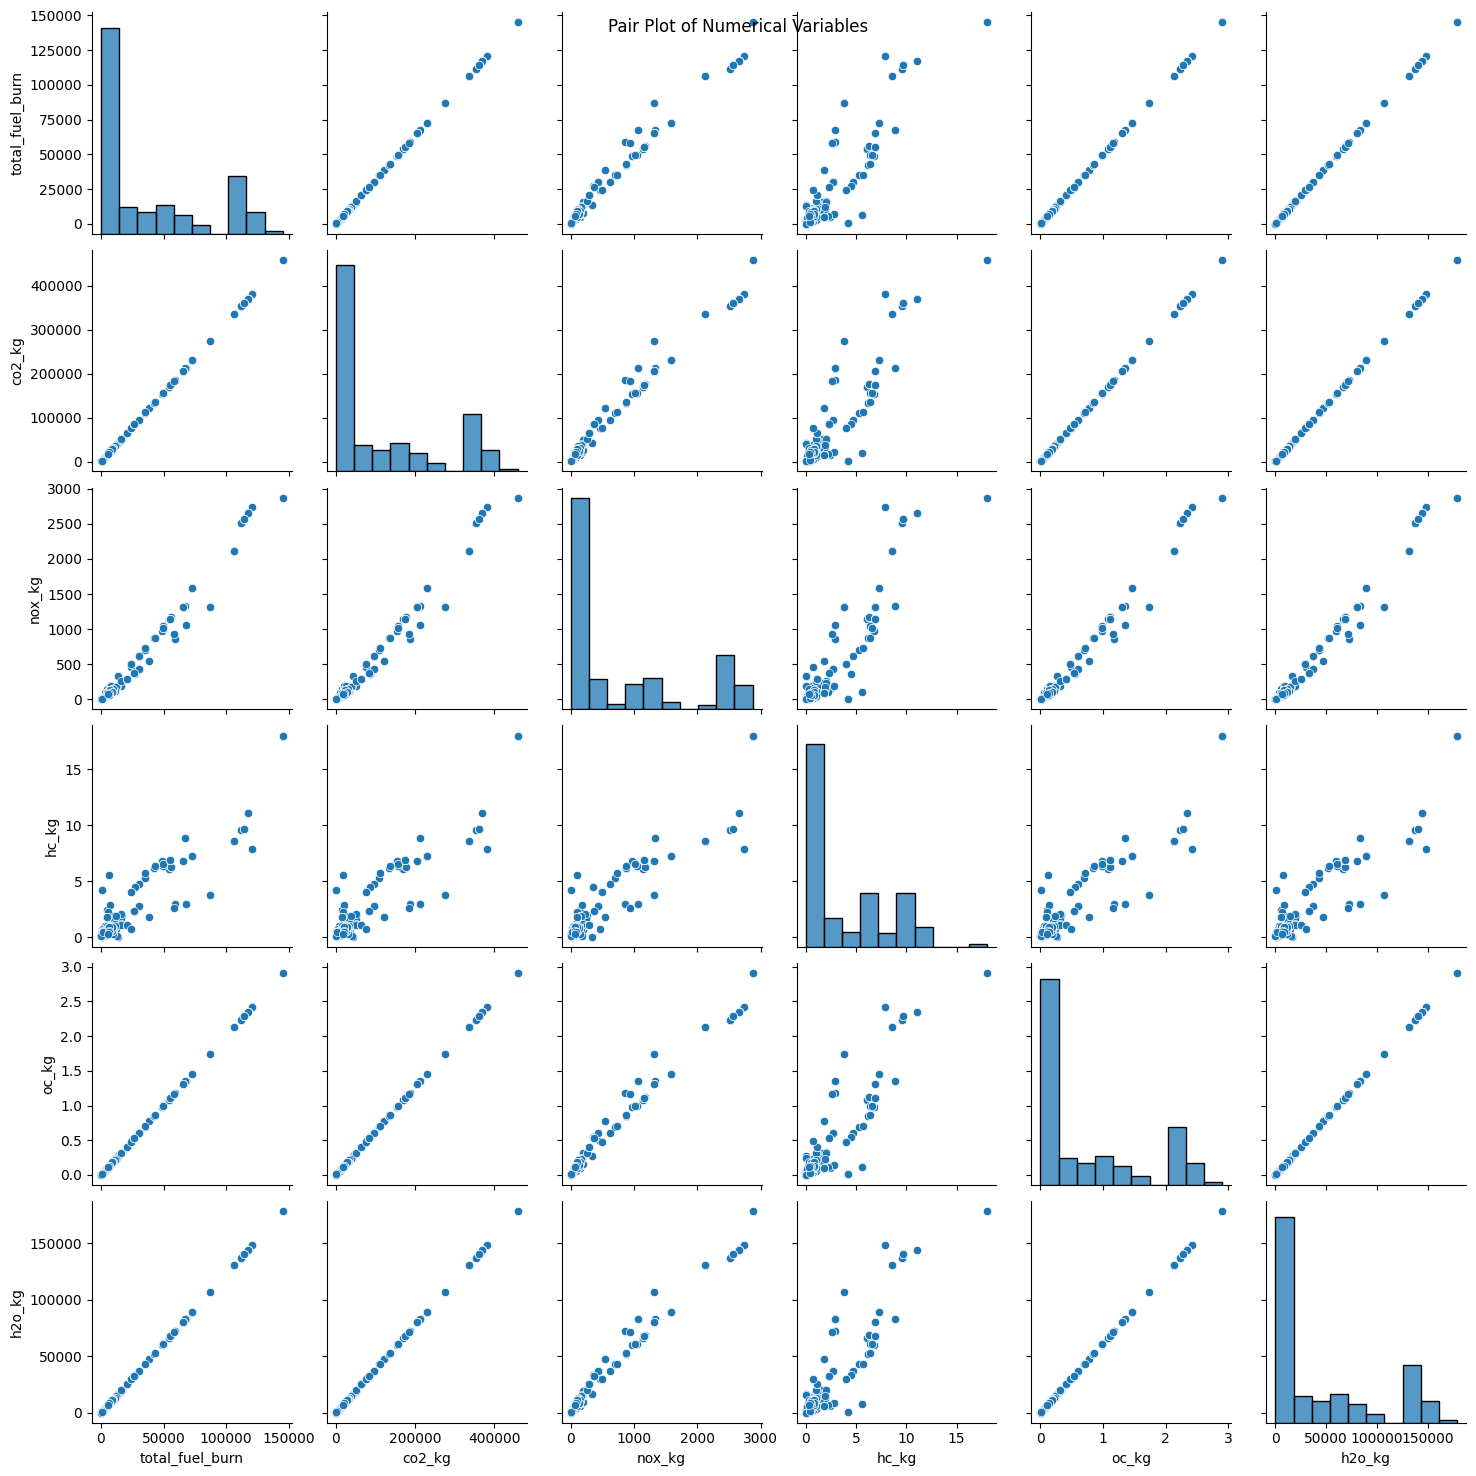

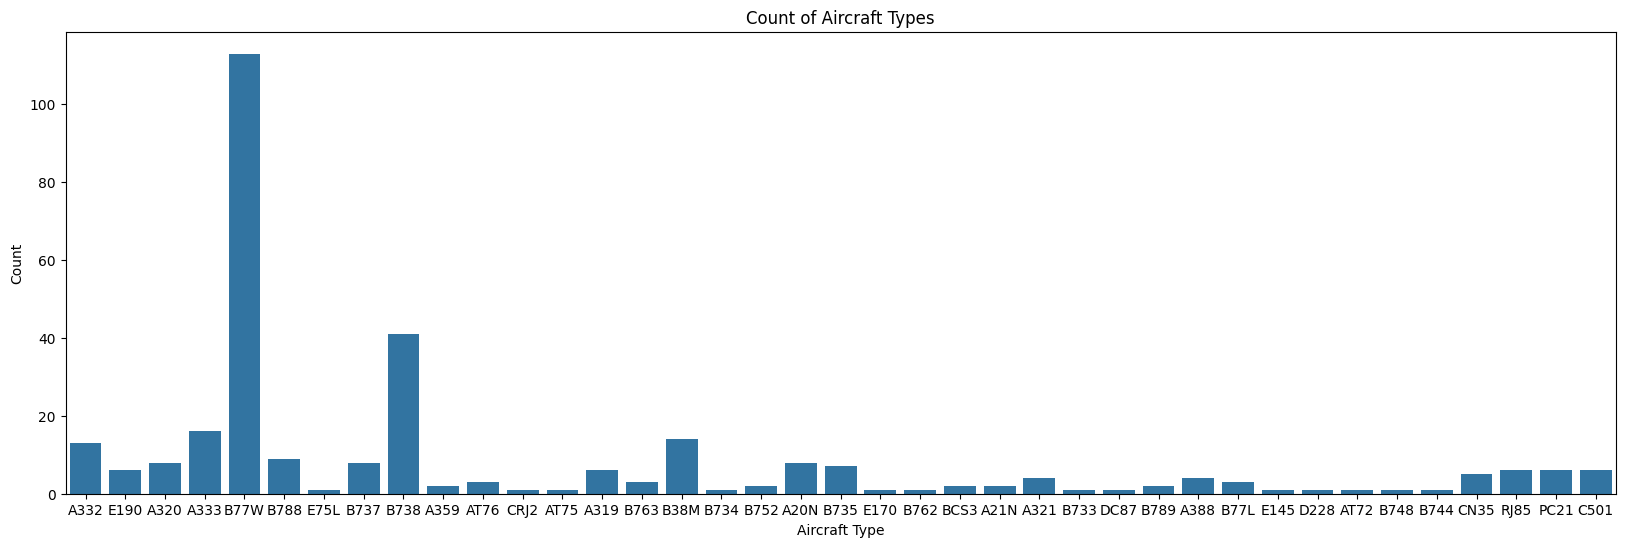

ValueError: Could not interpret value `country_code` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x800 with 0 Axes>

In [86]:
# Scatter Plots
sns.pairplot(all_flights_non_direct[['total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg']])
plt.suptitle('Pair Plot of Numerical Variables')
plt.show()

# Bar Plots
plt.figure(figsize=(20, 6))
sns.countplot(x='aircraft_type_icao', data=all_flights_non_direct)
plt.title('Count of Aircraft Types')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.show()

# Count Plots
plt.figure(figsize=(10, 8))
sns.countplot(x='country_code', data=all_flights_non_direct)
plt.title('Count of Country Codes')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.show()

## Old 
#### First_closest // Single iteration with further split

In [ ]:
merged_df = pd.merge(df_stopover, df, left_on=['icao', 'closest'], right_on=['origin_airport', 'destination_airport'], how='inner')
merged_df = merged_df.drop_duplicates(subset=['icao'], keep='first')
merged_df.reset_index(inplace=True)
merged_df = merged_df.rename(columns={'destination_airport':'hub_airport'})
merged_df = merged_df[['origin_airport','hub_airport',
       'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
       'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
       ]]
print(len(merged_df))
merged_df.iloc[:3]

0


,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai


##### Hub -> Dubai (First_closest)

In [ ]:
# Remaining flights to be found! 
occurrences_count = merged_df['origin_airport'].value_counts().to_dict()

# Delete the same number of occurrences from df_stopover['icao'] for each value in final_merged_df['origin_airport']
for value, count in occurrences_count.items():
    df_stopover = df_stopover.drop(df_stopover[df_stopover['icao'] == value].head(count).index)

len(df_stopover)

30

In [ ]:
results_closest = merged_df[['hub_airport','to_dubai']]
destination_dubai = pd.merge(results_closest, df, left_on=['hub_airport', 'to_dubai'], right_on=['origin_airport', 'destination_airport'], how='inner')
destination_dubai = destination_dubai.drop_duplicates(subset=['hub_airport'], keep='first')
destination_dubai.reset_index(inplace=True)
# destination_dubai = destination_dubai[['icao','first_closest','origin_airport','destination_airport',
#        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
#        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
#        ]]
print(len(destination_dubai))
destination_dubai = destination_dubai[['origin_airport','hub_airport',
       'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
       'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
       ]]
destination_dubai.iloc[:3]
# destination_dubai['hub_airport'].unique()
# destination_dubai['aircraft_type_icao'].unique()

0


,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai


In [ ]:
combined_dfs = []
# Iterate over unique hub_airport values
for hub_airport in merged_df['hub_airport'].unique():
    # Filter the row from destination_dubai
    row = destination_dubai[destination_dubai['origin_airport'] == hub_airport].iloc[0]

    # Number of times to add the row
    num_columns_to_add = (merged_df['hub_airport'] == hub_airport).sum()

    # Create a list of copies of row
    copies_of_row = [row] * num_columns_to_add

    # Concatenate the copies along the columns axis
    combined_df = pd.concat(copies_of_row, axis=1)

    # Transpose the DataFrame to have the rows and columns swapped
    combined_df = combined_df.T

    # Append the combined_df to the list
    combined_dfs.append(combined_df)

all_flights_non_direct = pd.concat([merged_df] + combined_dfs, ignore_index=True)
print(len(all_flights_non_direct))
all_flights_non_direct.iloc[:3]

0


,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai


## Heatmap

In [ ]:
scatter_geo = go.Scattergeo(
    locationmode='USA-states',  # Set location mode
    lon=df_stopover['longitude'],
    lat=df_stopover['latitude'],
    # text=df_stopover[''],
    mode='markers',
    marker=dict(
        size=df_stopover['total_delegates_sample']/100,
        # #color=df_stopover['total_delegates']/100,
        # colorscale='Viridis',  # Choose a color scale
        # colorbar=dict(title='Values'),  # Add color bar
        line_width=0.5
    )
)

# Create the layout for the figure
layout = go.Layout(
    title='Global Heatmap with Locations and Size Factor',
    geo=dict(
        scope='world',
        showland=True,
        landcolor='rgb(217, 217, 217)',  # Set the color of land areas
        showframe=False,  # Hide the frame
        projection_type='mercator'  # Choose projection type
    ),
    height=800,  # Increase the height of the plot
)

# Create the figure object
fig = go.Figure(data=[scatter_geo], layout=layout)

# Show the figure
fig.show()

In [14]:
# Sample data
locations = airport_location['country_code']
latitudes = airport_location['latitude']
longitudes = airport_location['longitude']
sizes = airport_location['total_delegates_sample']/15
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("origin_participants_sample.html")

In [ ]:
# basemap = folium.Map()
# FastMarkerCluster(airport_location[['latitude', 'longitude']]).add_to(basemap)
# HeatMap(airport_location[['latitude', 'longitude','total_delegates']],
#         ).add_to(basemap)
# basemap

basemap = folium.Map()
FastMarkerCluster(airport_location[['latitude', 'longitude']]).add_to(basemap)
HeatMap(airport_location[['latitude', 'longitude','total_delegates']],
        max_val=max(airport_location['total_delegates'])).add_to(basemap)
basemap

C:\Users\lukas\AppData\Local\Temp\ipykernel_14380\2891524790.py:9: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.

